In [383]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
from scipy.cluster.hierarchy import dendrogram

# SI 618 Final Project: EU Transportation Data

## Data Sources

The first step is to load our data into separate dataframes. We are collecting and analyzing datasets that concern countries in the EU, and key data points that are associated with transportation, such as train ridership, car usage, economic productivity, and spending on transportation infrastructure. The datasets we are pulling, which are from Eurostat and the International Transport Forum, are as follows:
- **GDP per capita in PPS:** Contains EU countries, along with their GDP per capita from 2010 to 2021.
- **Population** on 1 January by sex, country of birth and group of citizenship from 2010 to 2021.
- **Number of passenger cars per 1,000 inhabitants** in each country from 2010 to 2021.
- **Number of passengers transported by railways** in each country from 2010 to 2021.
- **Inland transportation investment** including investment expenditure on railways infrastructure, roads, and waterways from 2000 to 2020. Both road spending and inland transportation investment come from the same data source.

In [384]:
# Load all datasets from csv files into dataframes
gdp = pd.read_csv("datasets/gdp.csv")
population = pd.read_csv("datasets/populations.csv")
passenger_cars = pd.read_csv("datasets/cars_per_1000_inhabitants.csv")
passenger_railways = pd.read_csv("datasets/passengers_transported.csv")
transportation_investment = pd.read_csv("datasets/transportation_spending.csv")

Before manipulating the data, we want to assess what we have in all of the CSV files we are loading.

In [385]:
display(gdp.head(), population.head(), passenger_cars.head(), passenger_railways.head(), transportation_investment.head())

,DATAFLOW,LAST UPDATE,freq,na_item,ppp_cat,geo,TIME_PERIOD,OBS_VALUE,OBS_FLAG
0,ESTAT:TEC00114(1.0),06/01/23 11:00:00,A,VI_PPS_EU27_2020_HAB,GDP,AL,2010,29,NaN
1,ESTAT:TEC00114(1.0),06/01/23 11:00:00,A,VI_PPS_EU27_2020_HAB,GDP,AL,2011,30,NaN
2,ESTAT:TEC00114(1.0),06/01/23 11:00:00,A,VI_PPS_EU27_2020_HAB,GDP,AL,2012,30,NaN
3,ESTAT:TEC00114(1.0),06/01/23 11:00:00,A,VI_PPS_EU27_2020_HAB,GDP,AL,2013,29,NaN
4,ESTAT:TEC00114(1.0),06/01/23 11:00:00,A,VI_PPS_EU27_2020_HAB,GDP,AL,2014,30,NaN


,DATAFLOW,LAST UPDATE,freq,indic_de,geo,TIME_PERIOD,OBS_VALUE,OBS_FLAG
0,ESTAT:TPS00001(1.0),01/12/22 23:00:00,A,JAN,AD,2011,78115,b
1,ESTAT:TPS00001(1.0),01/12/22 23:00:00,A,JAN,AD,2012,78115,NaN
2,ESTAT:TPS00001(1.0),01/12/22 23:00:00,A,JAN,AD,2013,76246,NaN
3,ESTAT:TPS00001(1.0),01/12/22 23:00:00,A,JAN,AD,2016,71732,NaN
4,ESTAT:TPS00001(1.0),01/12/22 23:00:00,A,JAN,AD,2018,74794,e


,DATAFLOW,LAST UPDATE,freq,unit,geo,TIME_PERIOD,OBS_VALUE,OBS_FLAG
0,ESTAT:ROAD_EQS_CARHAB$DEFAULTVIEW(1.0),30/01/23 23:00:00,A,NR,AL,2013,118,NaN
1,ESTAT:ROAD_EQS_CARHAB$DEFAULTVIEW(1.0),30/01/23 23:00:00,A,NR,AL,2014,131,NaN
2,ESTAT:ROAD_EQS_CARHAB$DEFAULTVIEW(1.0),30/01/23 23:00:00,A,NR,AL,2015,140,NaN
3,ESTAT:ROAD_EQS_CARHAB$DEFAULTVIEW(1.0),30/01/23 23:00:00,A,NR,AL,2016,152,NaN
4,ESTAT:ROAD_EQS_CARHAB$DEFAULTVIEW(1.0),30/01/23 23:00:00,A,NR,AL,2017,147,NaN


,DATAFLOW,LAST UPDATE,freq,unit,geo,TIME_PERIOD,OBS_VALUE,OBS_FLAG
0,ESTAT:RAIL_PA_TOTAL(1.0),21/12/22 23:00:00,A,MIO_PKM,AT,2010,10263.0,NaN
1,ESTAT:RAIL_PA_TOTAL(1.0),21/12/22 23:00:00,A,MIO_PKM,AT,2011,10778.0,NaN
2,ESTAT:RAIL_PA_TOTAL(1.0),21/12/22 23:00:00,A,MIO_PKM,AT,2012,11211.0,NaN
3,ESTAT:RAIL_PA_TOTAL(1.0),21/12/22 23:00:00,A,MIO_PKM,AT,2013,11804.0,NaN
4,ESTAT:RAIL_PA_TOTAL(1.0),21/12/22 23:00:00,A,MIO_PKM,AT,2014,11981.0,NaN


,COUNTRY,Country,VARIABLE,Variable,MEASURE,Measure,YEAR,Year,Unit Code,Unit,PowerCode Code,PowerCode,Reference Period Code,Reference Period,Value,Flag Codes,Flags
0,ALB,Albania,I-INV-TOT-INLD,Total inland transport infrastructure investment,NAT,National currency,2000,2000,ALL,Lek,0,Units,NaN,NaN,1.464200e+10,NaN,NaN
1,ALB,Albania,I-INV-TOT-INLD,Total inland transport infrastructure investment,NAT,National currency,2001,2001,ALL,Lek,0,Units,NaN,NaN,1.400300e+10,NaN,NaN
2,ALB,Albania,I-INV-TOT-INLD,Total inland transport infrastructure investment,NAT,National currency,2002,2002,ALL,Lek,0,Units,NaN,NaN,9.275000e+09,NaN,NaN
3,ALB,Albania,I-INV-TOT-INLD,Total inland transport infrastructure investment,NAT,National currency,2003,2003,ALL,Lek,0,Units,NaN,NaN,8.460000e+09,NaN,NaN
4,ALB,Albania,I-INV-TOT-INLD,Total inland transport infrastructure investment,NAT,National currency,2004,2004,ALL,Lek,0,Units,NaN,NaN,1.189600e+10,NaN,NaN


## Data Wrangling

### Column Names

Our first step in data wrangling is to drop any columns that are not needed from each dataframe. There are some columns that included dataflow, indices, flags, and update dates that we are not concerned with, and duplicate codes. We also want to rename the columns to eliminate any capitalization and spaces so they are easier to access with Pandas. Finally, any columns that are not measured in Euros can be eliminated as well, because they are duplicative and we don't need local currency measurements.

In [386]:
# Drop columns that are not needed from each dataframe
gdp.drop(columns=['DATAFLOW', 'LAST UPDATE', 'freq', 'na_item', 'ppp_cat', 'OBS_FLAG'], inplace=True)
population.drop(columns=['DATAFLOW', 'LAST UPDATE', 'freq', 'indic_de', 'OBS_FLAG'], inplace=True)
passenger_cars.drop(columns=['DATAFLOW', 'LAST UPDATE', 'freq', 'unit', 'OBS_FLAG'], inplace=True)
passenger_railways.drop(columns=['DATAFLOW', 'LAST UPDATE', 'freq', 'OBS_FLAG'], inplace=True)
transportation_investment.drop(columns=['COUNTRY', 'VARIABLE',
                             'MEASURE', 'YEAR', 'Unit Code',
                            'Unit', 'PowerCode Code',
                            'PowerCode', 'Reference Period Code',
                            'Reference Period', 'Flag Codes',
                            'Flags'], inplace=True)

In [387]:
# Rename columns for consistency across all dataframes
gdp.rename(columns={"geo": "country", "TIME_PERIOD": "year", "OBS_VALUE": "gdp_per_capita"}, inplace=True)
population.rename(columns={"geo": "country", "TIME_PERIOD": "year", "OBS_VALUE": "population"}, inplace=True)
passenger_cars.rename(columns={"geo": "country", "TIME_PERIOD": "year", "OBS_VALUE": "passenger_cars_per_1000"}, inplace=True)
passenger_railways.rename(columns={"geo": "country", "TIME_PERIOD": "year", "OBS_VALUE": "passengers_transported"}, inplace=True)
transportation_investment.rename(columns={"Country": "country",
                                           "Year": "year",
                                            "Value": "value",
                                            "Variable": 'variable',
                                            'Measure': 'measure'},
                                            inplace=True)

In [388]:
# Only include the columns where Euro is the determined measure
# And where variable = "Total road spending" OR "Total inland transport infrastructure investment"
transportation_investment = transportation_investment[transportation_investment.measure == 'Euro']
transportation_investment = transportation_investment[transportation_investment.variable.isin(
    ['Total road spending', 'Total inland transport infrastructure investment'])]

### Filter Check

We want to check our value counts for each amount to ensure we are filtering our values properly.

In [389]:
# Value counts to ensure we filtered properly
transportation_investment['measure'].value_counts()

Euro    1748
Name: measure, dtype: int64

In [390]:
# Value counts to ensure we filtered properly
transportation_investment['variable'].value_counts()

Total inland transport infrastructure investment    938
Total road spending                                 810
Name: variable, dtype: int64

### Keep Euros Only

We can drop the 'measure' column, now that we know everything in our data is measured in Euros.

In [391]:
transportation_investment.drop(columns=['measure'], inplace=True)

### Dataframes Check

Next, we will preview all dataframes to ensure appropriate names and values are included.

In [392]:
passenger_cars.head()

,country,year,passenger_cars_per_1000
0,AL,2013,118
1,AL,2014,131
2,AL,2015,140
3,AL,2016,152
4,AL,2017,147


In [393]:
gdp.head()

,country,year,gdp_per_capita
0,AL,2010,29
1,AL,2011,30
2,AL,2012,30
3,AL,2013,29
4,AL,2014,30


In [394]:
population.head()

,country,year,population
0,AD,2011,78115
1,AD,2012,78115
2,AD,2013,76246
3,AD,2016,71732
4,AD,2018,74794


In [395]:
passenger_railways.head()

,unit,country,year,passengers_transported
0,MIO_PKM,AT,2010,10263.0
1,MIO_PKM,AT,2011,10778.0
2,MIO_PKM,AT,2012,11211.0
3,MIO_PKM,AT,2013,11804.0
4,MIO_PKM,AT,2014,11981.0


### passenger_railways cleaning

In order to only include values in 'THS_PAS' = thousand passengers and to remove the 'unit' column after filtering, we will filter the passenger railway data on 'unit'.

In [396]:
# see passenger railways shape before transformation
passenger_railways.shape

(799, 4)

In [397]:
passenger_railways = passenger_railways[passenger_railways['unit'] != 'MIO_PKM']
passenger_railways = passenger_railways.drop(columns=['unit'])
passenger_railways

,country,year,passengers_transported
414,AT,2010,239974.0
415,AT,2011,241526.0
416,AT,2012,260518.0
417,AT,2013,271888.0
418,AT,2014,270913.0
...,...,...,...
794,UK,2015,1741562.0
795,UK,2016,1772563.0
796,UK,2017,1757359.0
797,UK,2018,1783232.0


### Country Code Conversion

Because some of our data includes codes for countries, and other data includes full names, we want to standardize this across all data before we join all of it together. We will use a dictionary mapping these codes to countries and loop through the values in the data to replace all codes with country names. We will repeat this step for all datasets that came from Eurostat.

In [398]:
# Convert country codes into countries

#Dictionary with codes as keys and names as values
country_codes = {
    "BE": "Belgium",
    "BG": "Bulgaria",
    "CZ": "Czechia",
    "DE": "Germany",
    "DK": "Denmark",
    "EE": "Estonia",
    "IE": "Ireland",
    "EL": "Greece",
    "ES": "Spain",
    "FR": "France",
    "FX": "France (metropolitan)",
    "HR": "Croatia",
    "IT": "Italy",
    "CY": "Cyprus",
    "LV": "Latvia",
    "LT": "Lithuania",
    "LU": "Luxembourg",
    "HU": "Hungary",
    "MT": "Malta",
    "NL": "Netherlands",
    "AT": "Austria",
    "PL": "Poland",
    "PT": "Portugal",
    "RO": "Romania",
    "SI": "Slovenia",
    "SK": "Slovakia",
    "FI": "Finland",
    "SE": "Sweden",
    "IS": "Iceland",
    "LI": "Liechtenstein",
    "NO": "Norway",
    "CH": "Switzerland",
    "UK": "United Kingdom",
    "ME": "Montenegro",
    "MK": "North Macedonia",
    "AL": "Albania",
    "RS": "Serbia",
    "TR": "Turkey",
    "AD": "Andorra",
    "BY": "Belarus",
    "BA": "Bosnia",
    "XK": "Kosovo",
    "MD": "Moldova",
    "MC": "Monaco",
    "RU": "Russia",
    "SM": "San Marino",
    "UA": "Ukraine",
    "AM": "Armenia",
    "AZ": "Azerbaijan",
    "GE": "Georgia"
}

In [399]:
# update country code to country names for each dataframe
for idx, value in passenger_cars['country'].items():
   if value in country_codes:
      passenger_cars.loc[idx, 'country'] = country_codes[value]

In [400]:
passenger_cars.head()

,country,year,passenger_cars_per_1000
0,Albania,2013,118
1,Albania,2014,131
2,Albania,2015,140
3,Albania,2016,152
4,Albania,2017,147


In [401]:
# update country code to country names
for idx, value in passenger_railways['country'].items():
   if value in country_codes:
      passenger_railways.loc[idx, 'country'] = country_codes[value]

In [402]:
passenger_railways.head()

,country,year,passengers_transported
414,Austria,2010,239974.0
415,Austria,2011,241526.0
416,Austria,2012,260518.0
417,Austria,2013,271888.0
418,Austria,2014,270913.0


In [403]:
# Update country code to country names
for idx, value in population['country'].items():
   if value in country_codes:
      population.loc[idx, 'country'] = country_codes[value]

In [404]:
population.head()

,country,year,population
0,Andorra,2011,78115
1,Andorra,2012,78115
2,Andorra,2013,76246
3,Andorra,2016,71732
4,Andorra,2018,74794


In [405]:
# Update country code to country names
for idx, value in gdp['country'].items():
   if value in country_codes:
      gdp.loc[idx, 'country'] = country_codes[value]

In [406]:
gdp.head()

,country,year,gdp_per_capita
0,Albania,2010,29
1,Albania,2011,30
2,Albania,2012,30
3,Albania,2013,29
4,Albania,2014,30


### transportation_investment Cleaning

The transportation_investment dataframe consists of both inland transportation and road spending. We will make two tables of this one table, so we can join them all together in the end. We will do so by creating a copy of the table, filter each table to only include one type of value, and use these two separate tables to merge the data together afterward.

In [407]:
# Here the transportation_investment df includes both inland transportation and road spending
transportation_investment.head()

,country,variable,year,value
84,Albania,Total inland transport infrastructure investment,2000,1.104212e+08
85,Albania,Total inland transport infrastructure investment,2001,1.090002e+08
86,Albania,Total inland transport infrastructure investment,2002,7.009591e+07
87,Albania,Total inland transport infrastructure investment,2003,6.152459e+07
88,Albania,Total inland transport infrastructure investment,2004,9.316940e+07


In [408]:
# Make a copy of transportation_investment for road spending
road_spending = transportation_investment.copy()
road_spending.head()

,country,variable,year,value
84,Albania,Total inland transport infrastructure investment,2000,1.104212e+08
85,Albania,Total inland transport infrastructure investment,2001,1.090002e+08
86,Albania,Total inland transport infrastructure investment,2002,7.009591e+07
87,Albania,Total inland transport infrastructure investment,2003,6.152459e+07
88,Albania,Total inland transport infrastructure investment,2004,9.316940e+07


In [409]:
# Drop inland transport investment values
road_spending= road_spending[road_spending['variable'] != 'Total inland transport infrastructure investment']
road_spending

,country,variable,year,value
147,Albania,Total road spending,2000,1.121858e+08
148,Albania,Total road spending,2001,1.132736e+08
149,Albania,Total road spending,2002,7.128244e+07
150,Albania,Total road spending,2003,6.654982e+07
151,Albania,Total road spending,2004,9.790776e+07
...,...,...,...,...
10803,United States,Total road spending,2012,9.861154e+10
10804,United States,Total road spending,2013,9.549390e+10
10805,United States,Total road spending,2014,9.801550e+10
10806,United States,Total road spending,2015,1.199390e+11


In [410]:
# Drop the 'variable' column because it's no longer needed; rename 'value' column to 'total_road_spending'
road_spending = road_spending.drop(columns=['variable'])
road_spending.rename(columns={'value': 'total_road_spending'}, inplace=True)
road_spending

,country,year,total_road_spending
147,Albania,2000,1.121858e+08
148,Albania,2001,1.132736e+08
149,Albania,2002,7.128244e+07
150,Albania,2003,6.654982e+07
151,Albania,2004,9.790776e+07
...,...,...,...
10803,United States,2012,9.861154e+10
10804,United States,2013,9.549390e+10
10805,United States,2014,9.801550e+10
10806,United States,2015,1.199390e+11


In [411]:
# Make a copy of transportation_investment for inland transport investment
inland_transport_investment = transportation_investment.copy()
inland_transport_investment.head()

,country,variable,year,value
84,Albania,Total inland transport infrastructure investment,2000,1.104212e+08
85,Albania,Total inland transport infrastructure investment,2001,1.090002e+08
86,Albania,Total inland transport infrastructure investment,2002,7.009591e+07
87,Albania,Total inland transport infrastructure investment,2003,6.152459e+07
88,Albania,Total inland transport infrastructure investment,2004,9.316940e+07


In [412]:
# Drop total road spending values
inland_transport_investment = inland_transport_investment[inland_transport_investment['variable'] != 'Total road spending']
inland_transport_investment

,country,variable,year,value
84,Albania,Total inland transport infrastructure investment,2000,1.104212e+08
85,Albania,Total inland transport infrastructure investment,2001,1.090002e+08
86,Albania,Total inland transport infrastructure investment,2002,7.009591e+07
87,Albania,Total inland transport infrastructure investment,2003,6.152459e+07
88,Albania,Total inland transport infrastructure investment,2004,9.316940e+07
...,...,...,...,...
10730,United States,Total inland transport infrastructure investment,2015,9.614906e+10
10731,United States,Total inland transport infrastructure investment,2016,9.625700e+10
10732,United States,Total inland transport infrastructure investment,2017,9.586912e+10
10733,United States,Total inland transport infrastructure investment,2018,9.548201e+10


In [413]:
# Drop 'variable' column because it's no longer needed; rename 'value' column to 'total_inland_transport_investment'
inland_transport_investment = inland_transport_investment.drop(columns=['variable'])
inland_transport_investment.rename(columns={'value': 'total_inland_transport_investment'}, inplace=True)
inland_transport_investment

,country,year,total_inland_transport_investment
84,Albania,2000,1.104212e+08
85,Albania,2001,1.090002e+08
86,Albania,2002,7.009591e+07
87,Albania,2003,6.152459e+07
88,Albania,2004,9.316940e+07
...,...,...,...
10730,United States,2015,9.614906e+10
10731,United States,2016,9.625700e+10
10732,United States,2017,9.586912e+10
10733,United States,2018,9.548201e+10


### Merge

Now that we have cleaned all data, made country and monetary amounts consistent, and separated all types of data, we will be able to join every dataframe together. Every row has "country" and "year" values associated with it. We can join on these two values using a left join, which is a standard type of join. One by one, we will join all of the dataframes together until we have one table.

In [414]:
merged_df1 = passenger_cars.merge(passenger_railways, on=['country', 'year'], how='left')
merged_df1

,country,year,passenger_cars_per_1000,passengers_transported
0,Albania,2013,118,NaN
1,Albania,2014,131,NaN
2,Albania,2015,140,NaN
3,Albania,2016,152,NaN
4,Albania,2017,147,NaN
...,...,...,...,...
355,United Kingdom,2017,471,1757359.0
356,United Kingdom,2018,473,1783232.0
357,Kosovo,2017,94,NaN
358,Kosovo,2018,143,NaN


In [415]:
merged_df2 = merged_df1.merge(gdp, on=['country', 'year'], how='left')
merged_df2

,country,year,passenger_cars_per_1000,passengers_transported,gdp_per_capita
0,Albania,2013,118,NaN,29.0
1,Albania,2014,131,NaN,30.0
2,Albania,2015,140,NaN,30.0
3,Albania,2016,152,NaN,30.0
4,Albania,2017,147,NaN,30.0
...,...,...,...,...,...
355,United Kingdom,2017,471,1757359.0,107.0
356,United Kingdom,2018,473,1783232.0,105.0
357,Kosovo,2017,94,NaN,NaN
358,Kosovo,2018,143,NaN,NaN


In [416]:
merged_df3 = merged_df2.merge(population, on=['country', 'year'], how='left')
merged_df3

,country,year,passenger_cars_per_1000,passengers_transported,gdp_per_capita,population
0,Albania,2013,118,NaN,29.0,2897770
1,Albania,2014,131,NaN,30.0,2892394
2,Albania,2015,140,NaN,30.0,2885796
3,Albania,2016,152,NaN,30.0,2875592
4,Albania,2017,147,NaN,30.0,2876591
...,...,...,...,...,...,...
355,United Kingdom,2017,471,1757359.0,107.0,65844142
356,United Kingdom,2018,473,1783232.0,105.0,66273576
357,Kosovo,2017,94,NaN,NaN,1783531
358,Kosovo,2018,143,NaN,NaN,1798506


In [417]:
merged_df4 = merged_df3.merge(road_spending, on=['country', 'year'], how='left')
merged_df4

,country,year,passenger_cars_per_1000,passengers_transported,gdp_per_capita,population,total_road_spending
0,Albania,2013,118,NaN,29.0,2897770,2.429094e+08
1,Albania,2014,131,NaN,30.0,2892394,2.079811e+08
2,Albania,2015,140,NaN,30.0,2885796,1.876107e+08
3,Albania,2016,152,NaN,30.0,2875592,1.021451e+08
4,Albania,2017,147,NaN,30.0,2876591,1.726266e+08
...,...,...,...,...,...,...,...
355,United Kingdom,2017,471,1757359.0,107.0,65844142,1.110119e+10
356,United Kingdom,2018,473,1783232.0,105.0,66273576,1.100430e+10
357,Kosovo,2017,94,NaN,NaN,1783531,NaN
358,Kosovo,2018,143,NaN,NaN,1798506,NaN


In [418]:
merged_df5 = merged_df4.merge(inland_transport_investment, on=['country', 'year'], how='left')
merged_df5

,country,year,passenger_cars_per_1000,passengers_transported,gdp_per_capita,population,total_road_spending,total_inland_transport_investment
0,Albania,2013,118,NaN,29.0,2897770,2.429094e+08,2.348552e+08
1,Albania,2014,131,NaN,30.0,2892394,2.079811e+08,1.934331e+08
2,Albania,2015,140,NaN,30.0,2885796,1.876107e+08,1.798056e+08
3,Albania,2016,152,NaN,30.0,2875592,1.021451e+08,8.914034e+07
4,Albania,2017,147,NaN,30.0,2876591,1.726266e+08,1.590396e+08
...,...,...,...,...,...,...,...,...
355,United Kingdom,2017,471,1757359.0,107.0,65844142,1.110119e+10,2.224614e+10
356,United Kingdom,2018,473,1783232.0,105.0,66273576,1.100430e+10,2.221615e+10
357,Kosovo,2017,94,NaN,NaN,1783531,NaN,NaN
358,Kosovo,2018,143,NaN,NaN,1798506,NaN,NaN


Now we will want to check our unique country values to ensure all codes were transformed to a name, and make sure we remove any erroneous values.

In [419]:
# review unique country values to check all codes were transformed to a name
merged_df5['country'].unique()

array(['Albania', 'Austria', 'Belgium', 'Bulgaria', 'Switzerland',
       'Cyprus', 'Czechia', 'Germany', 'Denmark', 'Estonia', 'Greece',
       'Spain', 'EU27_2020', 'Finland', 'France', 'Croatia', 'Hungary',
       'Ireland', 'Iceland', 'Italy', 'Liechtenstein', 'Lithuania',
       'Luxembourg', 'Latvia', 'Montenegro', 'North Macedonia', 'Malta',
       'Netherlands', 'Norway', 'Poland', 'Portugal', 'Romania', 'Serbia',
       'Sweden', 'Slovenia', 'Slovakia', 'Turkey', 'United Kingdom',
       'Kosovo'], dtype=object)

In [420]:
# remove extraneous country names that did not have a match: 'EU27_2020'; print unique country values to ensure value was removed
merged_df5 = merged_df5[merged_df5['country'] != 'EU27_2020']
merged_df5['country'].unique()

array(['Albania', 'Austria', 'Belgium', 'Bulgaria', 'Switzerland',
       'Cyprus', 'Czechia', 'Germany', 'Denmark', 'Estonia', 'Greece',
       'Spain', 'Finland', 'France', 'Croatia', 'Hungary', 'Ireland',
       'Iceland', 'Italy', 'Liechtenstein', 'Lithuania', 'Luxembourg',
       'Latvia', 'Montenegro', 'North Macedonia', 'Malta', 'Netherlands',
       'Norway', 'Poland', 'Portugal', 'Romania', 'Serbia', 'Sweden',
       'Slovenia', 'Slovakia', 'Turkey', 'United Kingdom', 'Kosovo'],
      dtype=object)

### Drop null Values

How did we handle null values? We first wanted to check the numbers, and noticed there were particularly a lot of null values in total road spending and inland transportation investment. We chose to drop all null values, because having rows of incomplete data would make our future analysis more difficult. There will be tradeoffs to this, as we ended up with 150 rows, which might not be a robust enough dataset to use in some types of models, but we wanted to ensure that we had "complete" data for every row that we had.

In [421]:
# Check number of null values
merged_df5.isna().sum()

country                                0
year                                   0
passenger_cars_per_1000                0
passengers_transported                70
gdp_per_capita                        13
population                             0
total_road_spending                  160
total_inland_transport_investment    130
dtype: int64

In [422]:
# Drop null values
country_data = merged_df5.dropna()

In [423]:
country_data.shape

(150, 8)

In [424]:
country_data.head(20)

,country,year,passenger_cars_per_1000,passengers_transported,gdp_per_capita,population,total_road_spending,total_inland_transport_investment
9,Austria,2012,542,260518.0,133.0,8408121,8.440000e+08,2.018000e+09
10,Austria,2013,546,271888.0,133.0,8451860,9.220000e+08,2.022000e+09
11,Austria,2014,547,270913.0,132.0,8507786,1.120000e+09,2.030000e+09
12,Austria,2015,546,280060.0,131.0,8584926,1.147000e+09,2.006000e+09
13,Austria,2016,550,286990.0,130.0,8700471,1.141000e+09,1.969000e+09
14,Austria,2017,555,288503.0,127.0,8772865,1.202000e+09,2.070000e+09
15,Austria,2018,562,307647.0,127.0,8822267,1.189000e+09,2.148000e+09
16,Austria,2019,566,314892.0,126.0,8858775,1.314000e+09,2.303500e+09
17,Austria,2020,570,191272.0,125.0,8901064,1.339000e+09,2.553700e+09
29,Bulgaria,2012,385,26508.0,47.0,7327224,6.974128e+08,6.999693e+08


### Feature Engineering

Now that our data is prepared, we want to use feature engineering to create new columns. This will help us have more transformed features so we can improve performance of any machine learning techniques we choose to use.

##### View Initial Data

In [425]:
display(country_data.head())
display(country_data.shape)
display(country_data.info())
display(country_data.isnull().sum())
display(country_data.columns)
display(country_data['country'].unique())
display(country_data['year'].unique())

,country,year,passenger_cars_per_1000,passengers_transported,gdp_per_capita,population,total_road_spending,total_inland_transport_investment
9,Austria,2012,542,260518.0,133.0,8408121,8.440000e+08,2.018000e+09
10,Austria,2013,546,271888.0,133.0,8451860,9.220000e+08,2.022000e+09
11,Austria,2014,547,270913.0,132.0,8507786,1.120000e+09,2.030000e+09
12,Austria,2015,546,280060.0,131.0,8584926,1.147000e+09,2.006000e+09
13,Austria,2016,550,286990.0,130.0,8700471,1.141000e+09,1.969000e+09


(150, 8)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150 entries, 9 to 356
Data columns (total 8 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   country                            150 non-null    object 
 1   year                               150 non-null    int64  
 2   passenger_cars_per_1000            150 non-null    int64  
 3   passengers_transported             150 non-null    float64
 4   gdp_per_capita                     150 non-null    float64
 5   population                         150 non-null    int64  
 6   total_road_spending                150 non-null    float64
 7   total_inland_transport_investment  150 non-null    float64
dtypes: float64(4), int64(3), object(1)
memory usage: 10.5+ KB


None

country                              0
year                                 0
passenger_cars_per_1000              0
passengers_transported               0
gdp_per_capita                       0
population                           0
total_road_spending                  0
total_inland_transport_investment    0
dtype: int64

Index(['country', 'year', 'passenger_cars_per_1000', 'passengers_transported',
       'gdp_per_capita', 'population', 'total_road_spending',
       'total_inland_transport_investment'],
      dtype='object')

array(['Austria', 'Bulgaria', 'Switzerland', 'Denmark', 'Estonia',
       'Finland', 'France', 'Croatia', 'Hungary', 'Ireland', 'Italy',
       'Lithuania', 'Luxembourg', 'Latvia', 'Norway', 'Poland',
       'Portugal', 'Sweden', 'Slovenia', 'United Kingdom'], dtype=object)

array([2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020])

##### Region

We thought about how different regions might exhibit different patterns in transportation usage. Because of this, we thought to use a consistent source to map each country based on which region it belongs to. This will create a categorical attribute that we may be able to use in clustering, for example, to see if there is a significant difference between different groups.

In [426]:
# Break up country based on region, based on EuroVoc
regions = {
    'Austria': 'western_europe',
    'Switzerland': 'western_europe',
    'France': 'western_europe',
    'Ireland': 'western_europe',
    'Luxembourg': 'western_europe',
    'United Kingdom': 'western_europe',
    'Bulgaria': 'central_eastern_europe',
    'Croatia': 'central_eastern_europe',
    'Hungary': 'central_eastern_europe',
    'Poland': 'central_eastern_europe',
    'Slovenia': 'central_eastern_europe',
    'Denmark': 'northern_europe',
    'Estonia': 'northern_europe',
    'Finland': 'northern_europe',
    'Lithuania': 'northern_europe',
    'Latvia': 'northern_europe',
    'Norway': 'northern_europe',
    'Sweden': 'northern_europe',
    'Italy': 'southern_europe',
    'Portugal': 'southern_europe',
}

region_data = country_data.copy()
region_data['region'] = region_data['country'].map(regions)

region_data.head()

,country,year,passenger_cars_per_1000,passengers_transported,gdp_per_capita,population,total_road_spending,total_inland_transport_investment,region
9,Austria,2012,542,260518.0,133.0,8408121,8.440000e+08,2.018000e+09,western_europe
10,Austria,2013,546,271888.0,133.0,8451860,9.220000e+08,2.022000e+09,western_europe
11,Austria,2014,547,270913.0,132.0,8507786,1.120000e+09,2.030000e+09,western_europe
12,Austria,2015,546,280060.0,131.0,8584926,1.147000e+09,2.006000e+09,western_europe
13,Austria,2016,550,286990.0,130.0,8700471,1.141000e+09,1.969000e+09,western_europe


##### Population Size

Additionally, countries of different population sizes might have different priorities when it comes to investing in different forms of transporation. We wanted to illustrate country size with a categorical feature by mapping each country to a population size, which includes three buckets of relative size: small, medium, and large.

In [427]:
display(country_data.population.describe())
# Based on summary statistics of population, gave ChatGPT and asked for mapping
pop_size_mapping = {
    'Small': lambda x: x < 5_000_000,
    'Medium': lambda x: 5_000_000 <= x < 20_000_000,
    'Large': lambda x: x >= 20_000_000
}
# Map the population sizes to the 'pop_size' column
pop_data = region_data.copy()
pop_data['pop_size'] = pop_data['population'].apply(lambda x: next(key for key, value in pop_size_mapping.items() if value(x)))

display(pop_data.pop_size.value_counts())
display(pop_data.groupby('region').pop_size.value_counts())
display(pop_data.head())

count    1.500000e+02
mean     1.498089e+07
std      2.157131e+07
min      5.248530e+05
25%      2.797863e+06
50%      5.552904e+06
75%      9.825102e+06
max      6.748553e+07
Name: population, dtype: float64

Small     63
Medium    59
Large     28
Name: pop_size, dtype: int64

region                  pop_size
central_eastern_europe  Small       18
                        Medium      12
                        Large        6
northern_europe         Medium      28
                        Small       28
southern_europe         Large        8
                        Medium       2
western_europe          Medium      17
                        Small       17
                        Large       14
Name: pop_size, dtype: int64

,country,year,passenger_cars_per_1000,passengers_transported,gdp_per_capita,population,total_road_spending,total_inland_transport_investment,region,pop_size
9,Austria,2012,542,260518.0,133.0,8408121,8.440000e+08,2.018000e+09,western_europe,Medium
10,Austria,2013,546,271888.0,133.0,8451860,9.220000e+08,2.022000e+09,western_europe,Medium
11,Austria,2014,547,270913.0,132.0,8507786,1.120000e+09,2.030000e+09,western_europe,Medium
12,Austria,2015,546,280060.0,131.0,8584926,1.147000e+09,2.006000e+09,western_europe,Medium
13,Austria,2016,550,286990.0,130.0,8700471,1.141000e+09,1.969000e+09,western_europe,Medium


#### Spending and Passengers Transported per 1000

Finally another consideration we had to make was that different countries have different population sizes, and different resources, so it would be helpful to consider many of the monetary and numerical values on the same scale to account for this difference. We decided to model all of these values based on "passenger_cars_per_1000". Using simple calculations, we divided each of these values by the population number for each country, and multiplied it by 1000 to scale all of these values in a similar manner. This will make it easier for us to compare data.

In addition, we wanted to calculate spending for each country that eliminiates road investment, because we want to see the relationship between countries that spend more on public transit and non-car infrastructure and how much these services are used.

In [428]:
transportation_data = pop_data.copy()

# Calculate passengers transported per 1000 population by country and year
transportation_data['passengers_transported_per_1000'] = \
    (transportation_data['passengers_transported'] / transportation_data['population']) * 1000

# Calculate inland investment per 1000 population by country and year
transportation_data['inland_investment_per_1000'] = \
    (transportation_data['total_inland_transport_investment'] / transportation_data['population']) * 1000

# Calculate road spending per 1000 population by country and year
transportation_data['road_spending_per_1000'] = \
    (transportation_data['total_road_spending'] / transportation_data['population']) * 1000

# calculate non-road spending
transportation_data['non_road_spending'] = transportation_data['total_inland_transport_investment'] - transportation_data['total_road_spending']

# calculate non-road spending per 1000
transportation_data['non_road_spending_per_1000'] = \
    (transportation_data['non_road_spending'] / transportation_data['population']) * 1000

#### View Updated Data

Below, we have included the shape, head, information, and description of the new dataset that includes all new and cleaned features. We can see that there are 150 entries and 15 columns total.

In [429]:
display(transportation_data.head())
display(transportation_data.shape)
display(transportation_data.info())
display(transportation_data.isnull().sum())
display(transportation_data.columns)

,country,year,passenger_cars_per_1000,passengers_transported,gdp_per_capita,population,total_road_spending,total_inland_transport_investment,region,pop_size,passengers_transported_per_1000,inland_investment_per_1000,road_spending_per_1000,non_road_spending,non_road_spending_per_1000
9,Austria,2012,542,260518.0,133.0,8408121,8.440000e+08,2.018000e+09,western_europe,Medium,30.984093,240006.060807,100379.145352,1.174000e+09,139626.915455
10,Austria,2013,546,271888.0,133.0,8451860,9.220000e+08,2.022000e+09,western_europe,Medium,32.169014,239237.280315,109088.413675,1.100000e+09,130148.866640
11,Austria,2014,547,270913.0,132.0,8507786,1.120000e+09,2.030000e+09,western_europe,Medium,31.842950,238604.967262,131644.119869,9.100000e+08,106960.847393
12,Austria,2015,546,280060.0,131.0,8584926,1.147000e+09,2.006000e+09,western_europe,Medium,32.622296,233665.380459,133606.276862,8.590000e+08,100059.103596
13,Austria,2016,550,286990.0,130.0,8700471,1.141000e+09,1.969000e+09,western_europe,Medium,32.985571,226309.587148,131142.325513,8.280000e+08,95167.261634


(150, 15)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150 entries, 9 to 356
Data columns (total 15 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   country                            150 non-null    object 
 1   year                               150 non-null    int64  
 2   passenger_cars_per_1000            150 non-null    int64  
 3   passengers_transported             150 non-null    float64
 4   gdp_per_capita                     150 non-null    float64
 5   population                         150 non-null    int64  
 6   total_road_spending                150 non-null    float64
 7   total_inland_transport_investment  150 non-null    float64
 8   region                             150 non-null    object 
 9   pop_size                           150 non-null    object 
 10  passengers_transported_per_1000    150 non-null    float64
 11  inland_investment_per_1000         150 non-null    float64

None

country                              0
year                                 0
passenger_cars_per_1000              0
passengers_transported               0
gdp_per_capita                       0
population                           0
total_road_spending                  0
total_inland_transport_investment    0
region                               0
pop_size                             0
passengers_transported_per_1000      0
inland_investment_per_1000           0
road_spending_per_1000               0
non_road_spending                    0
non_road_spending_per_1000           0
dtype: int64

Index(['country', 'year', 'passenger_cars_per_1000', 'passengers_transported',
       'gdp_per_capita', 'population', 'total_road_spending',
       'total_inland_transport_investment', 'region', 'pop_size',
       'passengers_transported_per_1000', 'inland_investment_per_1000',
       'road_spending_per_1000', 'non_road_spending',
       'non_road_spending_per_1000'],
      dtype='object')

In [430]:
display(transportation_data.describe())

,year,passenger_cars_per_1000,passengers_transported,gdp_per_capita,population,total_road_spending,total_inland_transport_investment,passengers_transported_per_1000,inland_investment_per_1000,road_spending_per_1000,non_road_spending,non_road_spending_per_1000
count,150.000000,150.000000,1.500000e+02,150.000000,1.500000e+02,1.500000e+02,1.500000e+02,150.000000,1.500000e+02,1.500000e+02,1.500000e+02,150.000000
mean,2015.626667,501.873333,2.740963e+05,112.260000,1.498089e+07,3.138351e+09,3.814688e+09,17.826423,2.999852e+05,2.610757e+05,6.763373e+08,38909.462459
std,2.515847,94.155968,4.234211e+05,53.613385,2.157131e+07,4.195269e+09,5.876872e+09,16.730224,2.513449e+05,2.158719e+05,2.746606e+09,107635.580031
min,2012.000000,301.000000,3.238000e+03,46.000000,5.248530e+05,1.922000e+08,1.631000e+08,1.158875,2.688969e+04,3.671111e+04,-5.696000e+09,-214773.225736
25%,2013.000000,431.000000,1.969500e+04,74.000000,2.797863e+06,4.035000e+08,4.106782e+08,6.348290,1.294072e+05,1.382277e+05,-7.404447e+07,-16077.485355
50%,2015.500000,513.000000,6.879000e+04,104.000000,5.552904e+06,1.037605e+09,1.648500e+09,12.804816,2.075604e+05,1.811853e+05,1.700000e+07,5017.048100
75%,2018.000000,563.750000,2.716442e+05,129.000000,9.825102e+06,3.523378e+09,3.915846e+09,24.029419,3.632212e+05,3.231017e+05,4.378088e+08,94480.617385
max,2020.000000,682.000000,1.783232e+06,283.000000,6.748553e+07,1.602470e+10,2.373355e+10,74.386212,1.022040e+06,1.134319e+06,1.150134e+10,471456.715586


### Visual Analysis

In order to look at the distribution of our data, we used boxplots for all of the "normalized" values. The data seems to include many outliers for passengers transported, inland investment, road spending, and non-road spending per 1000 individuals.

#### Boxplots

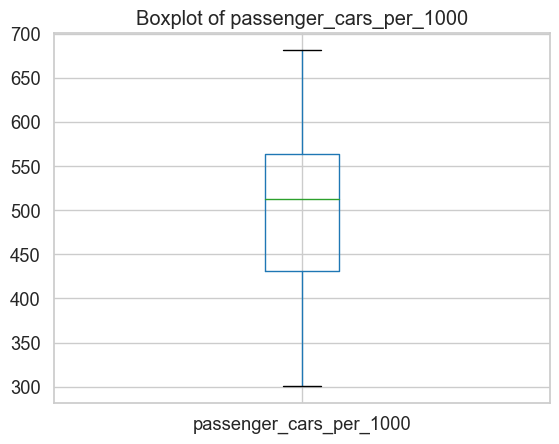

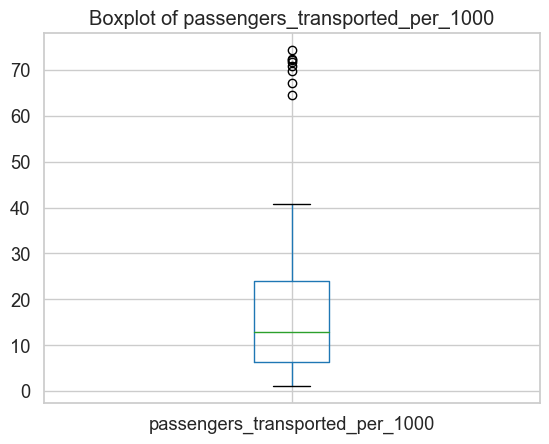

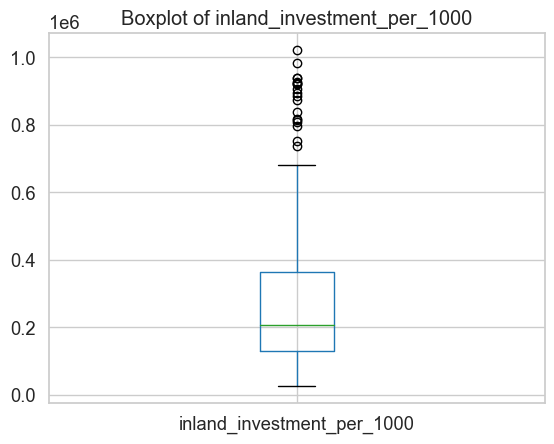

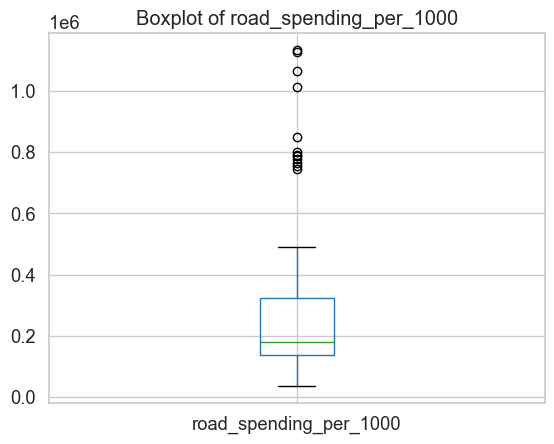

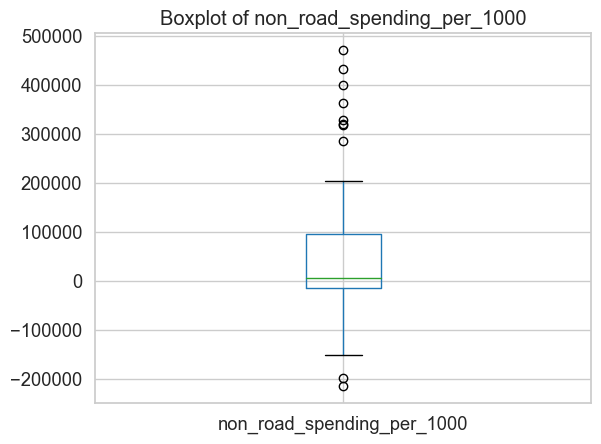

In [432]:
columns_to_plot = [
        'passenger_cars_per_1000',
        'passengers_transported_per_1000',
        'inland_investment_per_1000',
        'road_spending_per_1000',
        'non_road_spending_per_1000']
for column in columns_to_plot:
    fig, ax = plt.subplots()
    transportation_data[[column]].boxplot(ax=ax)
    ax.set_title('Boxplot of {}'.format(column))
    plt.show()

### EDA Write Up

- Shape:
    - 150 rows and 8 columns.
- Columns:
    - 'country':
        - 20 EU countries.
        - object
        - found in all 5 data sources.
    - 'year':
        - one of the 9 years that the data is for (2012 - 2020).
        - int64
        - found in all 5 data sources.
    - 'passenger_cars_per_1000':
        - number of passenger cars per 1000 population per year.
        - int64
        - found in 1 data source (cars_per_1000_inhabitants.csv)
    - 'passengers_transported':
        - number of railway passengers transported per year.
        - float64
        - found in 1 data source (passengers_transported.csv)
    - 'gdp_per_capita':
        - gdp per capita for that year.
        - float64
        - found in 1 data source (gdp.csv)
    - 'population':
        - population of a country per year.
        - int64
        - found in 1 data source (populations.csv)
    - 'total_road_spending':
        - Road spending and investment for specified year.
        - float64
        - found in 1 data source (transportation_spending.csv)
    - 'total_inland_transport_investment':
        - All spending related to road, train, maritine, etc.
        - float64
        - found in 1 data source (transportation_spending.csv)
- EU Countries:
    - 'Austria'
    - 'Bulgaria'
    - 'Switzerland'
    - 'Denmark'
    - 'Estonia',
    - 'Finland'
    - 'France'
    - 'Croatia'
    - 'Hungary'
    - 'Ireland'
    - 'Italy'
    - 'Lithuania'
    - 'Luxembourg'
    - 'Latvia'
    - 'Norway'
    - 'Poland'
    - 'Portugal'
    - 'Sweden'
    - 'Slovenia'
    - 'United Kingdom'

## Regression Analysis


Before deciding which methods to employ on our data, we wanted to explore what our data looked like. According to our scatterplot that shows passengers transported vs. non-road spending per 1000 people, we can see that theree seems to be some clusters but we aren't sure if there is a real relationship. In order to test some relationships, we can then conduct some OLS and linear regressions.

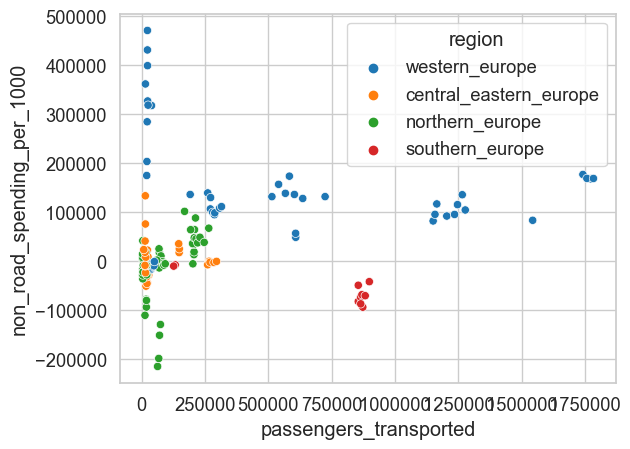

In [433]:
# Scatterplot of road spending, non road spending, etc. with region as hue
sns.scatterplot(data=transportation_data, x='passengers_transported', y='non_road_spending_per_1000', hue='region')
plt.ticklabel_format(style='plain', axis='y')
plt.ticklabel_format(style='plain', axis='x')

OLS (Ordinary Least Squares) regression is a type of linear regression that is commonly used to model the relationship between a dependent variable and one or more independent variables. OLS can give us the strength of a relationship, the statistical significance of a relationship, and the goodness of fit. To get a sense of what a regression would give us, we created models showing passengers transported as a function of non-road spending and passenger cars, as well as passengers transported as a function of just non-road spending. Both of our F-statistics (21.95 and 61.9, respectively) are much larger than 0.05, which suggests that there might be some sort of relationship between the variables. Because of this, we decided to try and run a linear regression using sk-learn and see how our model performs when we predict values against it.

In [435]:
# OLS Regression on passengers_transported as a function of non_road_spending
# F-statistic is really big, which means there is a difference
model1 = smf.ols('passengers_transported_per_1000 ~ non_road_spending_per_1000*passenger_cars_per_1000', data=transportation_data).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                  
===========================================================================================
Dep. Variable:     passengers_transported_per_1000   R-squared:                       0.311
Model:                                         OLS   Adj. R-squared:                  0.297
Method:                              Least Squares   F-statistic:                     21.95
Date:                             Fri, 07 Apr 2023   Prob (F-statistic):           8.66e-12
Time:                                     13:46:19   Log-Likelihood:                -607.00
No. Observations:                              150   AIC:                             1222.
Df Residuals:                                  146   BIC:                             1234.
Df Model:                                        3                                         
Covariance Type:                         nonrobust                                         
======================================================================================================================
                                                         coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------
Intercept                                              5.8101      6.678      0.870      0.386      -7.388      19.008
non_road_spending_per_1000                             0.0002   6.53e-05      2.650      0.009     4.4e-05       0.000
passenger_cars_per_1000                                0.0180      0.013      1.339      0.182      -0.009       0.045
non_road_spending_per_1000:passenger_cars_per_1000 -1.602e-07    1.1e-07     -1.459      0.147   -3.77e-07    5.69e-08
==============================================================================
Omnibus:                       61.156   Durbin-Watson:                   0.346
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              166.031
Skew:                           1.673   Prob(JB):                     8.85e-37
Kurtosis:                       6.921   Cond. No.                     3.99e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.99e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [436]:
# OLS Regression on passengers_transported as a function of non_road_spending
# F-statistic is really big, which means there is a difference
model2 = smf.ols('passengers_transported_per_1000 ~ non_road_spending_per_1000', data=transportation_data).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                  
===========================================================================================
Dep. Variable:     passengers_transported_per_1000   R-squared:                       0.295
Model:                                         OLS   Adj. R-squared:                  0.290
Method:                              Least Squares   F-statistic:                     61.90
Date:                             Fri, 07 Apr 2023   Prob (F-statistic):           7.00e-13
Time:                                     13:46:19   Log-Likelihood:                -608.72
No. Observations:                              150   AIC:                             1221.
Df Residuals:                                  148   BIC:                             1227.
Df Model:                                        1                                         
Covariance Type:                         nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     14.5422      1.224     11.878      0.000      12.123      16.962
non_road_spending_per_1000  8.441e-05   1.07e-05      7.868      0.000    6.32e-05       0.000
==============================================================================
Omnibus:                       65.564   Durbin-Watson:                   0.324
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              184.252
Skew:                           1.793   Prob(JB):                     9.78e-41
Kurtosis:                       7.076   Cond. No.                     1.21e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.21e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [437]:
transportation_data.head()

,country,year,passenger_cars_per_1000,passengers_transported,gdp_per_capita,population,total_road_spending,total_inland_transport_investment,region,pop_size,passengers_transported_per_1000,inland_investment_per_1000,road_spending_per_1000,non_road_spending,non_road_spending_per_1000
9,Austria,2012,542,260518.0,133.0,8408121,8.440000e+08,2.018000e+09,western_europe,Medium,30.984093,240006.060807,100379.145352,1.174000e+09,139626.915455
10,Austria,2013,546,271888.0,133.0,8451860,9.220000e+08,2.022000e+09,western_europe,Medium,32.169014,239237.280315,109088.413675,1.100000e+09,130148.866640
11,Austria,2014,547,270913.0,132.0,8507786,1.120000e+09,2.030000e+09,western_europe,Medium,31.842950,238604.967262,131644.119869,9.100000e+08,106960.847393
12,Austria,2015,546,280060.0,131.0,8584926,1.147000e+09,2.006000e+09,western_europe,Medium,32.622296,233665.380459,133606.276862,8.590000e+08,100059.103596
13,Austria,2016,550,286990.0,130.0,8700471,1.141000e+09,1.969000e+09,western_europe,Medium,32.985571,226309.587148,131142.325513,8.280000e+08,95167.261634


The LinearRegression model in scikit-learn is an OLS (Ordinary Least Squares) linear regression algorithm. We chose to use a linear regression because we want to see the relationship between a dependent variable (in this case, passengers transported by train) and several dependent variables. In order to create this model, we  conducted a stratified shuffle split, which is a cross-validation technique that keeps the proportion samples for each class the same in order to account for class imbalances - we have way fewer values classified as "Southern Europe" which is why it is important to "correct" for this in our model.

After preparing the input data, and using a OneHotEncoder to encode categorical attributes in order to be used in the model, the model will fit a linear function by minimizing the sum of least squared residuals between predicted and actual values. OLS will estimate all coefficients of the linear function by minimizing the sum of squared errors. After training, fitting, and testing the model, we can cross-validate our model and use the negative root mean squared error as a performance metric to show the average squared difference between the predicted and actual values of the independent variable. The lower this value is, the better our model performs.

The default value for the test size is 0.1. We created two separate models, one with the default setting, and one with 0.33 to see if the proportion of the total dataset being used has any effect on our RMSE results.

In [438]:
# Update transportation_data to remove any columns that aren't standardized
regression_columns = ['country', 'year',
                    'passenger_cars_per_1000',
                    'population',
                    'region',
                    'pop_size',
                    'passengers_transported_per_1000',
                    'inland_investment_per_1000',
                    'road_spending_per_1000',
                    'non_road_spending_per_1000']
transportation_data = transportation_data[regression_columns]

In [439]:
transportation_data.region.value_counts()

northern_europe           56
western_europe            48
central_eastern_europe    36
southern_europe           10
Name: region, dtype: int64

In [440]:
# We did a 0.1 - we don't have enough data, it overfits with 0.1
# We used stratified shuffle split
split = StratifiedShuffleSplit(n_splits=1, random_state=42)

# Two tuple of index values returned
for train_index, test_index in split.split(transportation_data, transportation_data['region']):
    strat_train_set = transportation_data.iloc[train_index]
    strat_test_set = transportation_data.iloc[test_index]

# AKA features matrix
country_X = strat_train_set.drop('passengers_transported_per_1000', axis=1)
country_y = strat_train_set['passengers_transported_per_1000']

cat_attribs = country_X.select_dtypes(exclude=np.number).columns
num_attribs = country_X.select_dtypes(include=np.number).columns

# Create pipeline to encode categorical attributes
full_pipeline = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown='ignore'), cat_attribs),
    ("num", StandardScaler(), num_attribs)
])

country_prepared = full_pipeline.fit_transform(country_X)

# Fit linear regression model
lm = LinearRegression()
lm = lm.fit(country_prepared, country_y)

# Test model
first_five = country_X.iloc[:5]
first_five_prepared = full_pipeline.transform(first_five)
lm.predict(first_five_prepared)

array([ 7.12683354, 17.53384761,  3.32896256, 69.81699477,  5.16100435])

In [441]:
# Get accuracy score
result = cross_validate(lm, country_prepared, country_y, scoring="neg_root_mean_squared_error")

# put minus sign in front of mean
-np.mean(result['test_score']), np.std(result['test_score'])

(2.24883203227417, 1.1102805340138377)

In [442]:
# Use it to predict against scenarios
country_X = strat_test_set.drop('passengers_transported_per_1000', axis='columns')
country_y = strat_test_set[['passengers_transported_per_1000']]

country_test_prepared = full_pipeline.transform(country_X)
result = cross_validate(lm, country_test_prepared, country_y, scoring="neg_root_mean_squared_error")
result

{'fit_time': array([0.00296998, 0.00714302, 0.00285625, 0.00265598, 0.00271225]),
 'score_time': array([0.00064397, 0.00097895, 0.00072193, 0.00075102, 0.00071597]),
 'test_score': array([-25.18450667, -18.40783574, -17.60651909, -16.89727399,
         -3.17249432])}

In [443]:
# Our values are large compared to train, which is not ideal and means we are overfitting
-np.mean(result['test_score']), np.std(result['test_score'])

(16.2537259632303, 7.179998016538794)

We can see that our accuracy score of the train vs test data differs significantly. The ideal value for an RMSE is approaching 0, but our values for the test data are at 16 and 7, which is larger than the 2 and 1 from the train data, meaning that our model is likely overfitting. But what happens when we create a similar model and increase the test size?

In [444]:
# Run again with test_size = 0.33
# We used stratified shuffle split
split = StratifiedShuffleSplit(n_splits=1, random_state=42, test_size = 0.33)

# Two tuple of index values returned
for train_index, test_index in split.split(transportation_data, transportation_data['region']):
    strat_train_set = transportation_data.iloc[train_index]
    strat_test_set = transportation_data.iloc[test_index]

# AKA features matrix
country_X = strat_train_set.drop('passengers_transported_per_1000', axis=1)
country_y = strat_train_set['passengers_transported_per_1000']

cat_attribs = country_X.select_dtypes(exclude=np.number).columns
num_attribs = country_X.select_dtypes(include=np.number).columns

# If we don't have handle_unknown it results in an error - a ountry has no data
full_pipeline = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown='ignore'), cat_attribs),
    ("num", StandardScaler(), num_attribs)
])

country_prepared = full_pipeline.fit_transform(country_X)

lm = LinearRegression()
lm = lm.fit(country_prepared, country_y)

# Test model
first_five = country_X.iloc[:5]
first_five_prepared = full_pipeline.transform(first_five)
lm.predict(first_five_prepared)

array([37.57924201,  7.25262343, 69.85905463, 14.68287906,  3.31768069])

In [445]:
# Get accuracy score
result = cross_validate(lm, country_prepared, country_y, scoring="neg_root_mean_squared_error")

# put minus sign in front of mean
-np.mean(result['test_score']), np.std(result['test_score'])

(2.8521496285407624, 0.9039969791697445)

In [446]:
# Use it to predict against scenarios
country_X = strat_test_set.drop('passengers_transported_per_1000', axis='columns')
country_y = strat_test_set[['passengers_transported_per_1000']]

country_test_prepared = full_pipeline.transform(country_X)
result = cross_validate(lm, country_test_prepared, country_y, scoring="neg_root_mean_squared_error")
result

{'fit_time': array([0.00500488, 0.00473022, 0.00429082, 0.004107  , 0.00412989]),
 'score_time': array([0.00080705, 0.00076199, 0.00054288, 0.0006299 , 0.00054812]),
 'test_score': array([ -4.2508171 ,  -9.40110078, -26.19678092, -14.93682579,
         -5.04083636])}

In [447]:
# lm model will overfit due to lack of data
-np.mean(result['test_score']), np.std(result['test_score'])

(11.965272189386111, 8.06723714373765)

Adjusting the test size to 0.33 made the average and standard deviation of the test scores slightly smaller and larger, respectively. Regardless, these values are still muvh bigger than the train data's results, which tells us that updating the test size did change the results but not in a way that indicates to us that this is a particularly good model to use.

The RMSE tells us the average squared difference between the predicted and actual values of the dependent variables - for a model to be considered "useful" you want to minimize this value, and ensure that you are checking for it after creating the model. Even after some adjustments, we have determined that although creating a linear regression in this format is possible, it might not be the best way to go. Our dataset may simply be too small given what we are trying to accomplish, so our resulting model will overfit.

After furthering our analysis with clustering, we will try to simplify our approach by using the earlier OLS method and reducing the number of variables we are including, in order to possibly improve our RMSE values.

## Clustering Analysis

__Tyler change to pdf titles genius!__

### Setup

In [448]:
clustering_columns = ['pop_size', 'region', 'country',
                    'passenger_cars_per_1000',
                    'passengers_transported_per_1000',
                    'inland_investment_per_1000',
                    'road_spending_per_1000',
                    'non_road_spending_per_1000']
clustering_data = transportation_data[clustering_columns]

In [449]:
display(clustering_data.head())
clustering_data = clustering_data.reset_index()
clustering_data = clustering_data.drop('index',axis=1)
display(clustering_data.head())

,pop_size,region,country,passenger_cars_per_1000,passengers_transported_per_1000,inland_investment_per_1000,road_spending_per_1000,non_road_spending_per_1000
9,Medium,western_europe,Austria,542,30.984093,240006.060807,100379.145352,139626.915455
10,Medium,western_europe,Austria,546,32.169014,239237.280315,109088.413675,130148.866640
11,Medium,western_europe,Austria,547,31.842950,238604.967262,131644.119869,106960.847393
12,Medium,western_europe,Austria,546,32.622296,233665.380459,133606.276862,100059.103596
13,Medium,western_europe,Austria,550,32.985571,226309.587148,131142.325513,95167.261634


,pop_size,region,country,passenger_cars_per_1000,passengers_transported_per_1000,inland_investment_per_1000,road_spending_per_1000,non_road_spending_per_1000
0,Medium,western_europe,Austria,542,30.984093,240006.060807,100379.145352,139626.915455
1,Medium,western_europe,Austria,546,32.169014,239237.280315,109088.413675,130148.866640
2,Medium,western_europe,Austria,547,31.842950,238604.967262,131644.119869,106960.847393
3,Medium,western_europe,Austria,546,32.622296,233665.380459,133606.276862,100059.103596
4,Medium,western_europe,Austria,550,32.985571,226309.587148,131142.325513,95167.261634


In [450]:
X = clustering_data.drop(columns=['pop_size', 'region', 'country'])
Y_pop = clustering_data[['pop_size']]
Y_region = clustering_data[['region']]
Y_country = clustering_data[['country']]
# display(X.shape, Y_pop.shape, Y_region.shape, Y_country.shape)
# display(X, Y_pop, Y_region, Y_country)

In [451]:
pipe_pop_clustering = Pipeline([
    ('scale',StandardScaler()),
    ('cluster', AgglomerativeClustering(n_clusters=3)),
])

pipe_region_clustering = Pipeline([
    ('scale',StandardScaler()),
    ('cluster', AgglomerativeClustering(n_clusters=4)),
])

pipe_country_clustering = Pipeline([
    ('scale',StandardScaler()),
    ('cluster', AgglomerativeClustering(n_clusters=20)),
])

# display(pipe_pop_clustering, pipe_region_clustering, pipe_country_clustering)

In [452]:
Y_pred_pop = pipe_pop_clustering.fit_predict(X)
Y_pred_region = pipe_region_clustering.fit_predict(X)
Y_pred_country = pipe_country_clustering.fit_predict(X)
# display(Y_pred_pop.shape, Y_pred_region.shape, Y_pred_country.shape)
# display(Y_pred_pop, Y_pred_region, Y_pred_country)

In [453]:
# Authors: Mathew Kallada & Chris Teplovs
# License: BSD 3 clause
"""
=========================================
Plot Hierarachical Clustering Dendrogram
=========================================
This example plots the corresponding dendrogram of a hierarchical clustering
using AgglomerativeClustering and the dendrogram method available in scipy.
"""

def plot_dendrogram(model, **kwargs):

    # Children of hierarchical clustering
    children = model.named_steps.cluster.children_

    # Distances between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(children.shape[0])

    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0]+2)

    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)


    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

    threshold = kwargs.pop('color_threshold',None)
    if threshold is not None:
        plt.axhline(threshold,color='red')

### Population Size Clustering

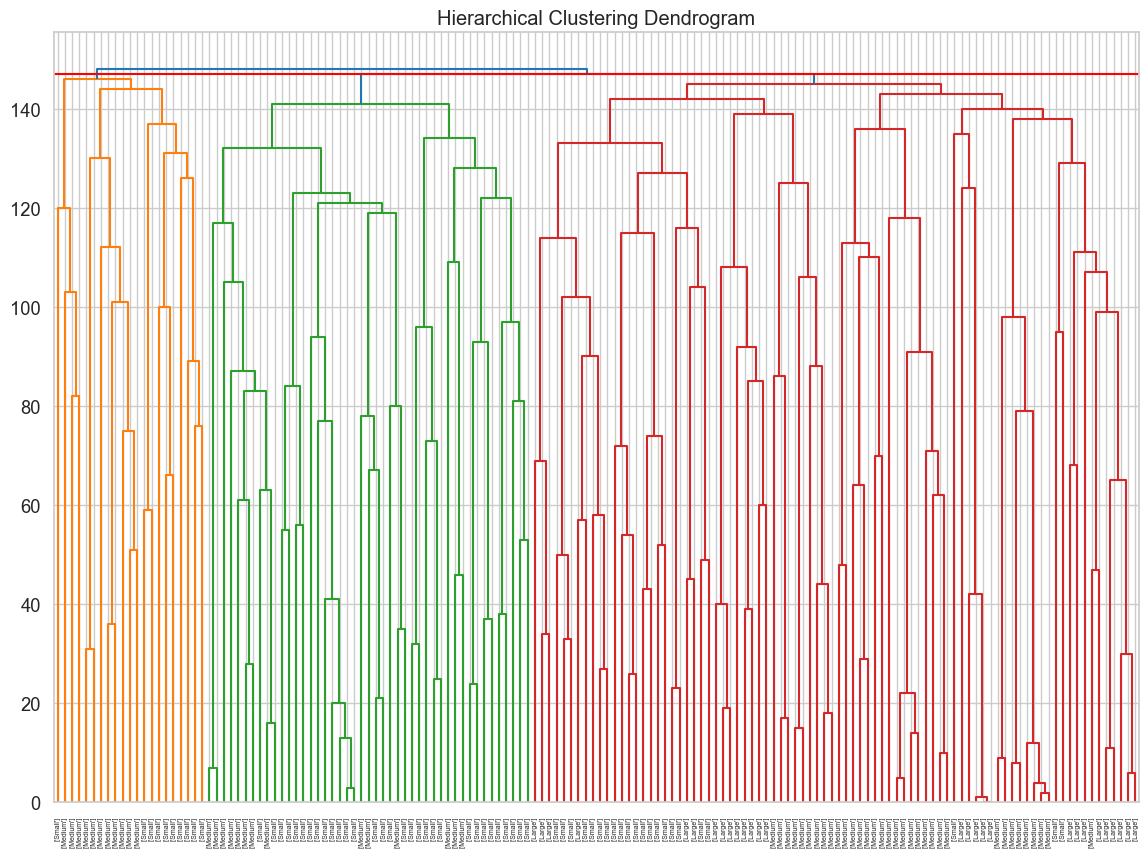

In [454]:
plt.figure(figsize=(14,10))
plt.title('Hierarchical Clustering Dendrogram')

plot_dendrogram(pipe_pop_clustering,labels=Y_pop.values, color_threshold=147)

plt.xticks(rotation=90)
plt.savefig('Clustering.pdf')
plt.show()

In [455]:
pop_size_clustering = pd.concat([pd.DataFrame(Y_pred_pop), Y_pop, X], axis=1)
pop_size_clustering = pop_size_clustering.rename(columns={0:'Y_pred_pop'})
# display(pop_size_clustering)

In [456]:
pop_crosstab = pd.crosstab(
    pop_size_clustering['pop_size'],
    pop_size_clustering['Y_pred_pop'],
    margins=True)
display(pop_crosstab)

Y_pred_pop,0,1,2,All
pop_size,,,,
Large,0,28,0,28
Medium,11,34,14,59
Small,10,22,31,63
All,21,84,45,150


### Region Clustering

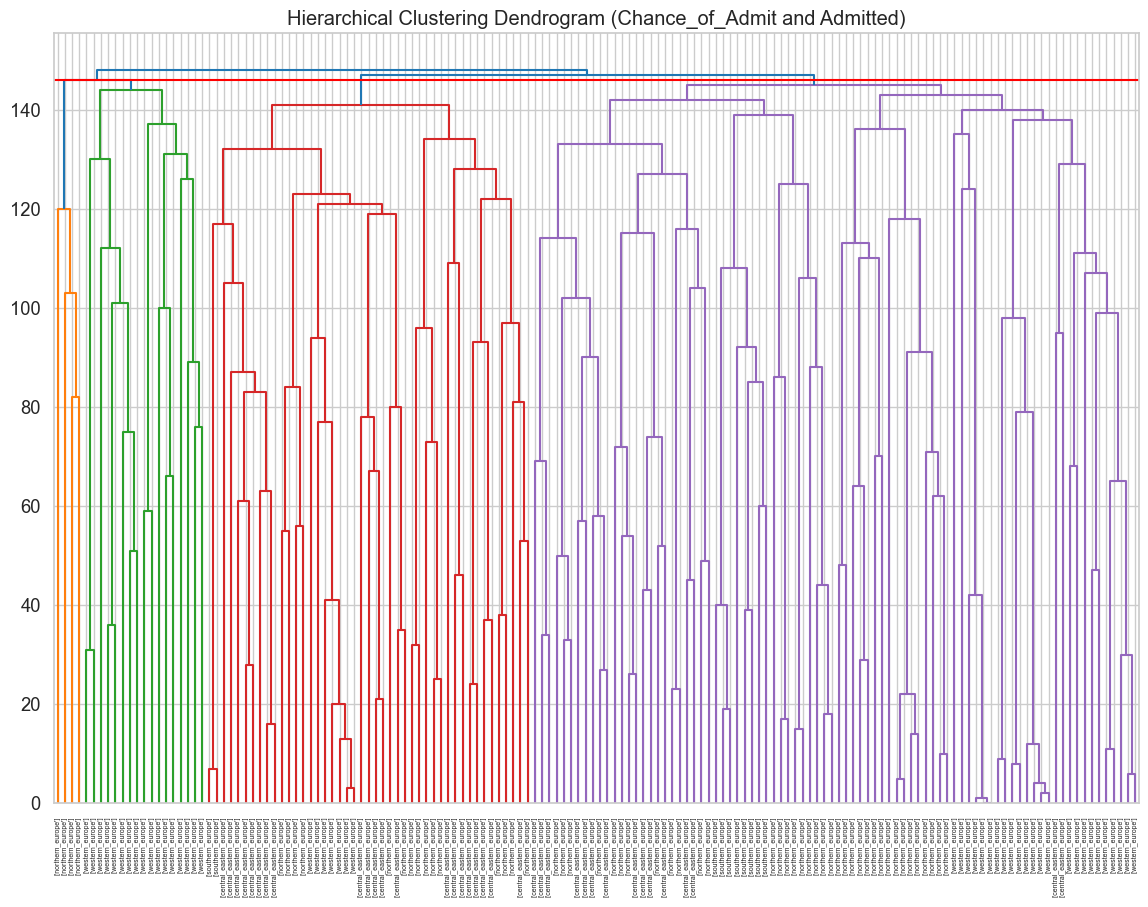

In [457]:
plt.figure(figsize=(14,10))
plt.title('Hierarchical Clustering Dendrogram (Chance_of_Admit and Admitted)')

plot_dendrogram(pipe_region_clustering,labels=Y_region.values, color_threshold=146)

plt.xticks(rotation=90)
plt.savefig('Region_Clustering.pdf')
plt.show()

In [458]:
region_clustering = pd.concat([pd.DataFrame(Y_pred_region), Y_region, X], axis=1)
region_clustering = region_clustering.rename(columns={0:'Y_pred_region'})
# display(region_clustering)

In [459]:
reg_crosstab = pd.crosstab(
    region_clustering['region'],
    region_clustering['Y_pred_region'],
    margins=True)
display(reg_crosstab)

Y_pred_region,0,1,2,3,All
region,,,,,
central_eastern_europe,15,0,21,0,36
northern_europe,37,0,15,4,56
southern_europe,8,0,2,0,10
western_europe,24,17,7,0,48
All,84,17,45,4,150


### Country Clustering

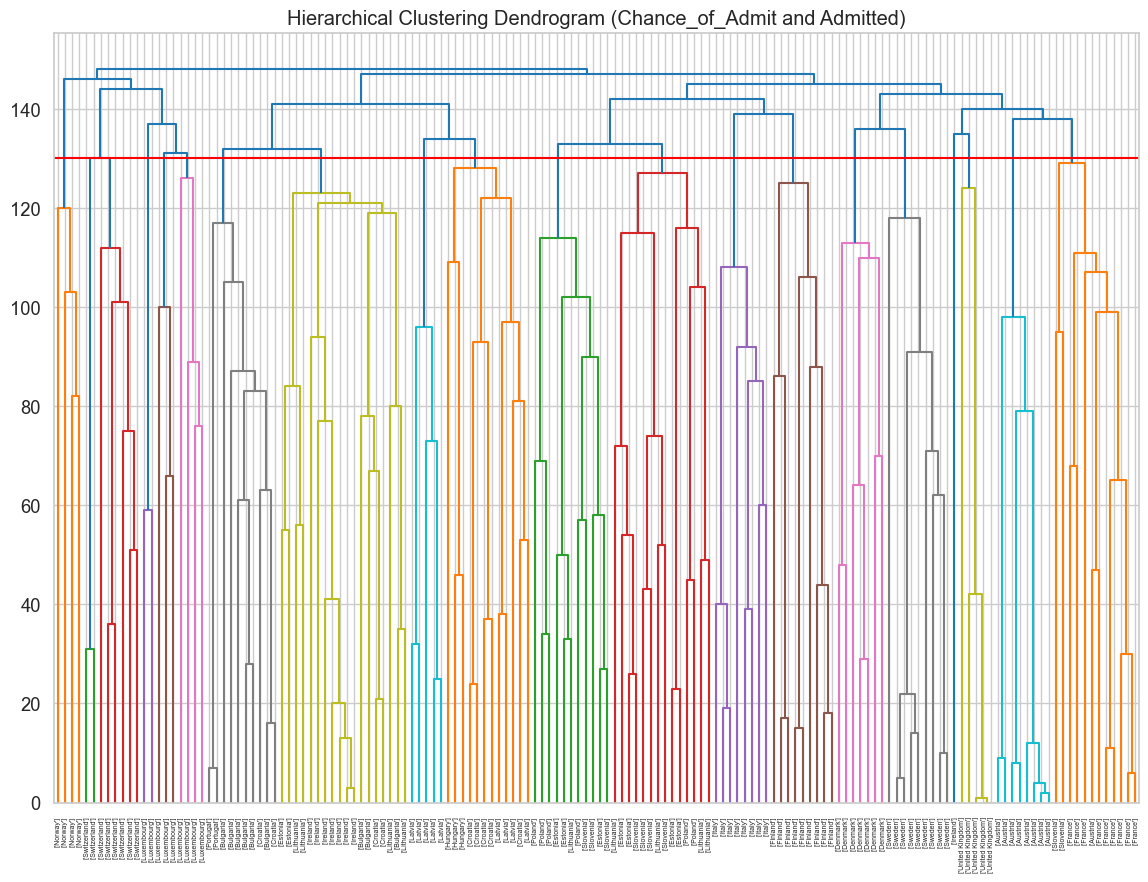

In [460]:
plt.figure(figsize=(14,10))
plt.title('Hierarchical Clustering Dendrogram (Chance_of_Admit and Admitted)')

plot_dendrogram(pipe_country_clustering,labels=Y_country.values, color_threshold=130)

plt.xticks(rotation=90)
plt.savefig('Country_Clustering.pdf')
plt.show()

In [461]:
country_clustering = pd.concat([pd.DataFrame(Y_pred_country), Y_country, X], axis=1)
country_clustering = country_clustering.rename(columns={0:'Y_pred_country'})
display(country_clustering)

,Y_pred_country,country,passenger_cars_per_1000,passengers_transported_per_1000,inland_investment_per_1000,road_spending_per_1000,non_road_spending_per_1000
0,11,Austria,542,30.984093,240006.060807,100379.145352,139626.915455
1,11,Austria,546,32.169014,239237.280315,109088.413675,130148.866640
2,11,Austria,547,31.842950,238604.967262,131644.119869,106960.847393
3,11,Austria,546,32.622296,233665.380459,133606.276862,100059.103596
4,11,Austria,550,32.985571,226309.587148,131142.325513,95167.261634
...,...,...,...,...,...,...,...
145,3,United Kingdom,449,24.305203,225582.304335,141870.624417,83711.679918
146,3,United Kingdom,463,26.853830,365956.881470,188613.167194,177343.714276
147,3,United Kingdom,469,27.112097,337608.193170,169278.732785,168329.460385
148,3,United Kingdom,471,26.689679,337860.575509,168598.015067,169262.560442


In [462]:
country_crosstab = pd.crosstab(
    country_clustering['country'],
    country_clustering['Y_pred_country'],
    margins=True)
display(country_crosstab)

Y_pred_country,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,All
country,,,,,,,,,,,,,,,,,,,,,
Austria,1,0,0,0,0,0,0,0,0,0,...,8,0,0,0,0,0,0,0,0,9
Bulgaria,0,0,0,0,0,3,0,0,6,0,...,0,0,0,0,0,0,0,0,0,9
Croatia,0,5,0,0,0,2,0,0,2,0,...,0,0,0,0,0,0,0,0,0,9
Denmark,0,0,0,0,0,0,0,0,0,0,...,0,0,7,0,0,0,0,0,0,7
Estonia,0,0,0,0,4,2,0,0,0,0,...,0,0,0,0,0,3,0,0,0,9
Finland,0,0,0,0,0,0,9,0,0,0,...,0,0,0,0,0,0,0,0,0,9
France,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
Hungary,0,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
Ireland,0,0,0,0,0,7,0,0,0,0,...,0,0,0,1,0,0,0,0,0,8


## OLS Linear Regression Using Statsmodels

As mentioned earlier, we can use the Statsmodels package to fit an OLS linear regression model to transportation_data. First, we will try it on two variables, and then increase the number of independent variables to see if increasing the "complexity" of our model will help our RMSE scores.

In [463]:
# OLS Regression on passengers_transported as a function of non_road_spending
# F-statistic is really big, which means there is a difference
model3 = smf.ols('passengers_transported_per_1000 ~ non_road_spending_per_1000*passenger_cars_per_1000', data=transportation_data).fit()
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                  
===========================================================================================
Dep. Variable:     passengers_transported_per_1000   R-squared:                       0.311
Model:                                         OLS   Adj. R-squared:                  0.297
Method:                              Least Squares   F-statistic:                     21.95
Date:                             Fri, 07 Apr 2023   Prob (F-statistic):           8.66e-12
Time:                                     13:46:25   Log-Likelihood:                -607.00
No. Observations:                              150   AIC:                             1222.
Df Residuals:                                  146   BIC:                             1234.
Df Model:                                        3                                         
Covariance Type:                         nonrobust                                         
======================================================================================================================
                                                         coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------
Intercept                                              5.8101      6.678      0.870      0.386      -7.388      19.008
non_road_spending_per_1000                             0.0002   6.53e-05      2.650      0.009     4.4e-05       0.000
passenger_cars_per_1000                                0.0180      0.013      1.339      0.182      -0.009       0.045
non_road_spending_per_1000:passenger_cars_per_1000 -1.602e-07    1.1e-07     -1.459      0.147   -3.77e-07    5.69e-08
==============================================================================
Omnibus:                       61.156   Durbin-Watson:                   0.346
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              166.031
Skew:                           1.673   Prob(JB):                     8.85e-37
Kurtosis:                       6.921   Cond. No.                     3.99e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.99e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Below, we will predict our values using the model, and then create regression plots to observe the model's behavior.

In [464]:
# non_road_spending_per_1000*passenger_cars_per_1000
y_pred = model3.predict(transportation_data[['non_road_spending_per_1000', 'passenger_cars_per_1000']])

In [465]:
y_pred

9      27.613091
10     26.784989
11     24.802434
12     24.211186
13     23.803868
         ...    
352    22.365229
353    31.683946
354    30.739373
355    30.812517
356    30.785852
Length: 150, dtype: float64

eval_env: 1


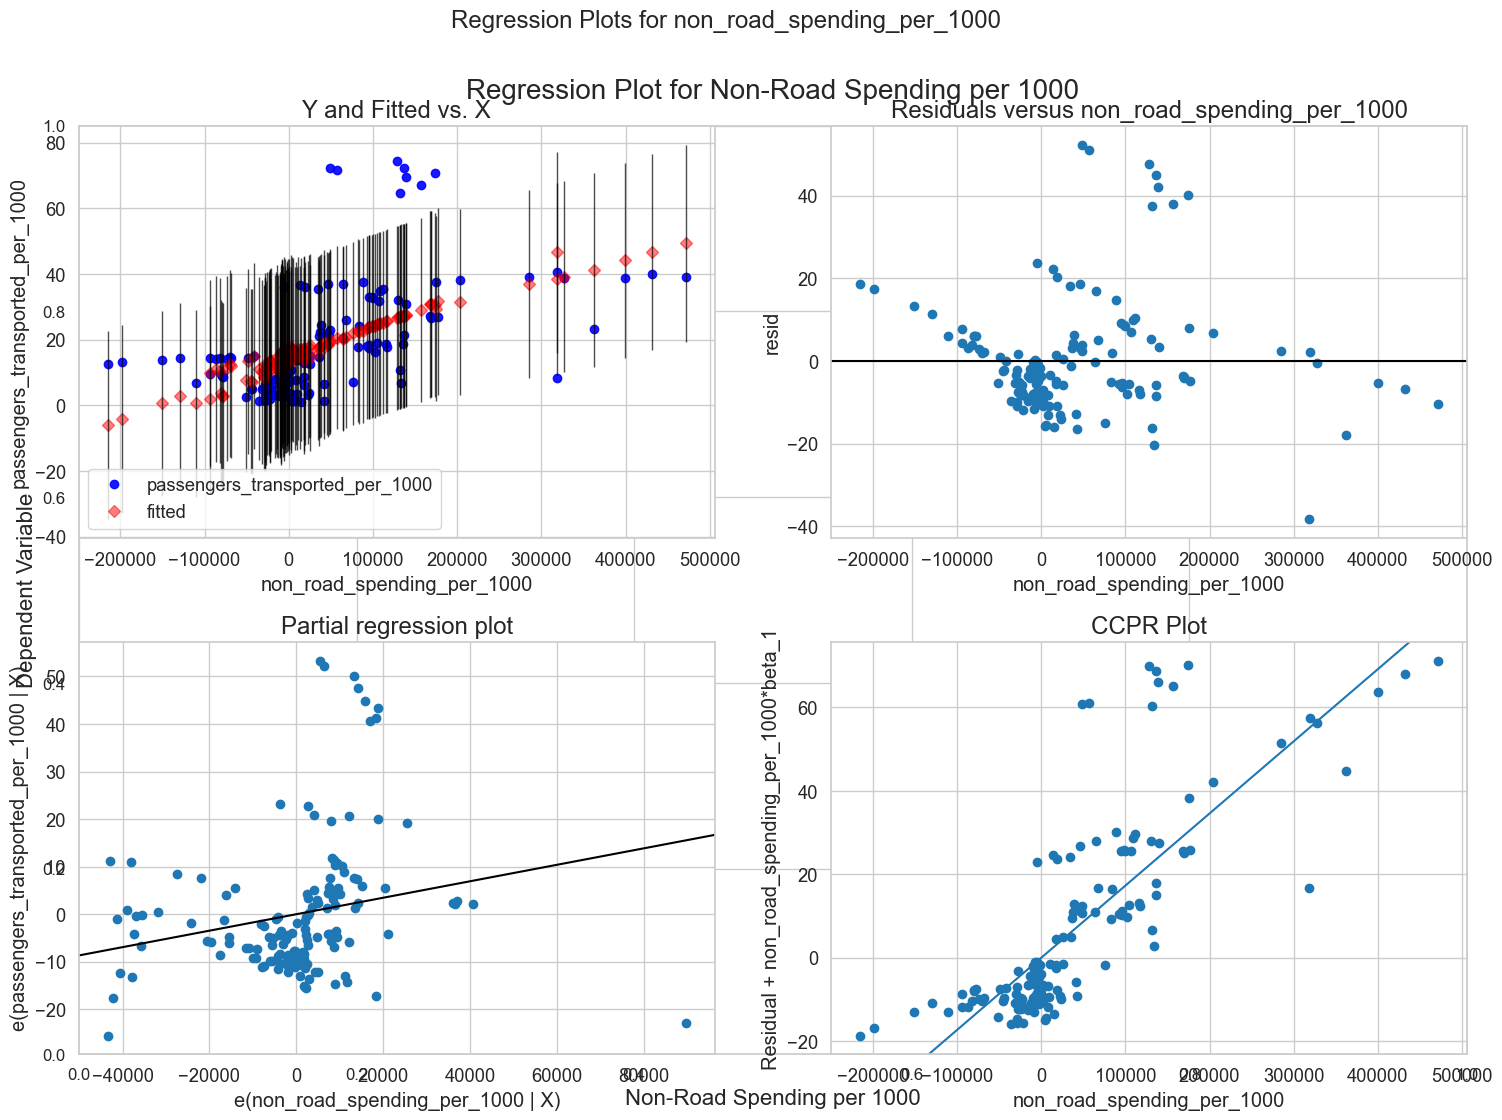

In [466]:
# Set the style and context for the plot
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.2)

# Create the regression plot with a larger figsize
fig, ax = plt.subplots(figsize=(16, 12))
sm.graphics.plot_regress_exog(model3, 'non_road_spending_per_1000', fig=fig)

# Customize the plot
ax.set_title("Regression Plot for Non-Road Spending per 1000", fontsize=20, pad=20)
ax.set_xlabel("Non-Road Spending per 1000", fontsize=16)
ax.set_ylabel("Dependent Variable", fontsize=16)

# Set the tick labels
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)

# Adjust spacing between subplots
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Tighten layout
fig.tight_layout()

# Show the plot
plt.show()

Finally, we will calculate RMSE, which is 13.84, and the squared RMSE, which is 192. These values are relatively high, but we can add more variables to our final model to see if that makes a difference.

In [467]:
# Get y_actual
y_actual = transportation_data['passengers_transported_per_1000']

# Calculate the residuals
residuals = y_actual - y_pred

# Calculate the mean of squared residuals
mse = np.mean(residuals**2)

# Calculate the RMSE
rmse = np.sqrt(np.mean(residuals**2))

print("RMSE:", rmse)

RMSE: 13.842573228806666


In [468]:
# indicates performance of OLS model - lower is better
squared_rmse = rmse**2
squared_rmse

191.616833594875

We will repeat all of the same steps from model3 for model4, as follows:

In [469]:
# OLS Regression on passengers_transported as a function of non_road_spending
# F-statistic is really big, which means there is a difference
model4 = smf.ols('passengers_transported_per_1000~non_road_spending_per_1000*passenger_cars_per_1000*inland_investment_per_1000*road_spending_per_1000', data=transportation_data).fit()
model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                  
===========================================================================================
Dep. Variable:     passengers_transported_per_1000   R-squared:                       0.803
Model:                                         OLS   Adj. R-squared:                  0.790
Method:                              Least Squares   F-statistic:                     63.25
Date:                             Fri, 07 Apr 2023   Prob (F-statistic):           6.09e-45
Time:                                     13:46:27   Log-Likelihood:                -513.23
No. Observations:                              150   AIC:                             1046.
Df Residuals:                                  140   BIC:                             1077.
Df Model:                                        9                                         
Covariance Type:                         nonrobust                                         
========================================================================================================================================================================
                                                                                                           coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                              7.67e-16   6.32e-17     12.142      0.000    6.42e-16    8.92e-16
non_road_spending_per_1000                                                                            3.498e-10   9.89e-11      3.539      0.001    1.54e-10    5.45e-10
passenger_cars_per_1000                                                                               6.169e-13   8.21e-14      7.515      0.000    4.55e-13    7.79e-13
non_road_spending_per_1000:passenger_cars_per_1000                                                    1.738e-07   4.92e-08      3.536      0.001    7.67e-08    2.71e-07
inland_investment_per_1000                                                                            2.272e-10   3.25e-11      6.991      0.000    1.63e-10    2.91e-10
non_road_spending_per_1000:inland_investment_per_1000                                                -4.971e-10    3.8e-10     -1.307      0.193   -1.25e-09    2.55e-10
passenger_cars_per_1000:inland_investment_per_1000                                                    1.496e-07   2.58e-08      5.798      0.000    9.86e-08    2.01e-07
non_road_spending_per_1000:passenger_cars_per_1000:inland_investment_per_1000                         3.921e-13   8.08e-13      0.485      0.628   -1.21e-12    1.99e-12
road_spending_per_1000                                                                               -1.004e-10   6.25e-11     -1.605      0.111   -2.24e-10    2.32e-11
non_road_spending_per_1000:road_spending_per_1000                                                     1.656e-10   4.86e-10      0.341      0.734   -7.95e-10    1.13e-09
passenger_cars_per_1000:road_spending_per_1000                                                       -2.427e-08   2.44e-08     -0.993      0.322   -7.26e-08     2.4e-08
non_road_spending_per_1000:passenger_cars_per_1000:road_spending_per_1000                            -6.807e-13   9.28e-13     -0.734      0.464   -2.51e-12    1.15e-12
inland_investment_per_1000:road_spending_per_1000                                                     2.442e-10   5.87e-11      4.159      0.000    1.28e-10     3.6e-10
non_road_spending_per_1000:inland_investment_per_1000:road_spending_per_1000                          1.119e-15   1.06e-15      1.051      0.295   -9.87e-16    3.22e-15
passenger_cars_per_1000:inland_investment_per_1000:road_spending_pe

eval_env: 1


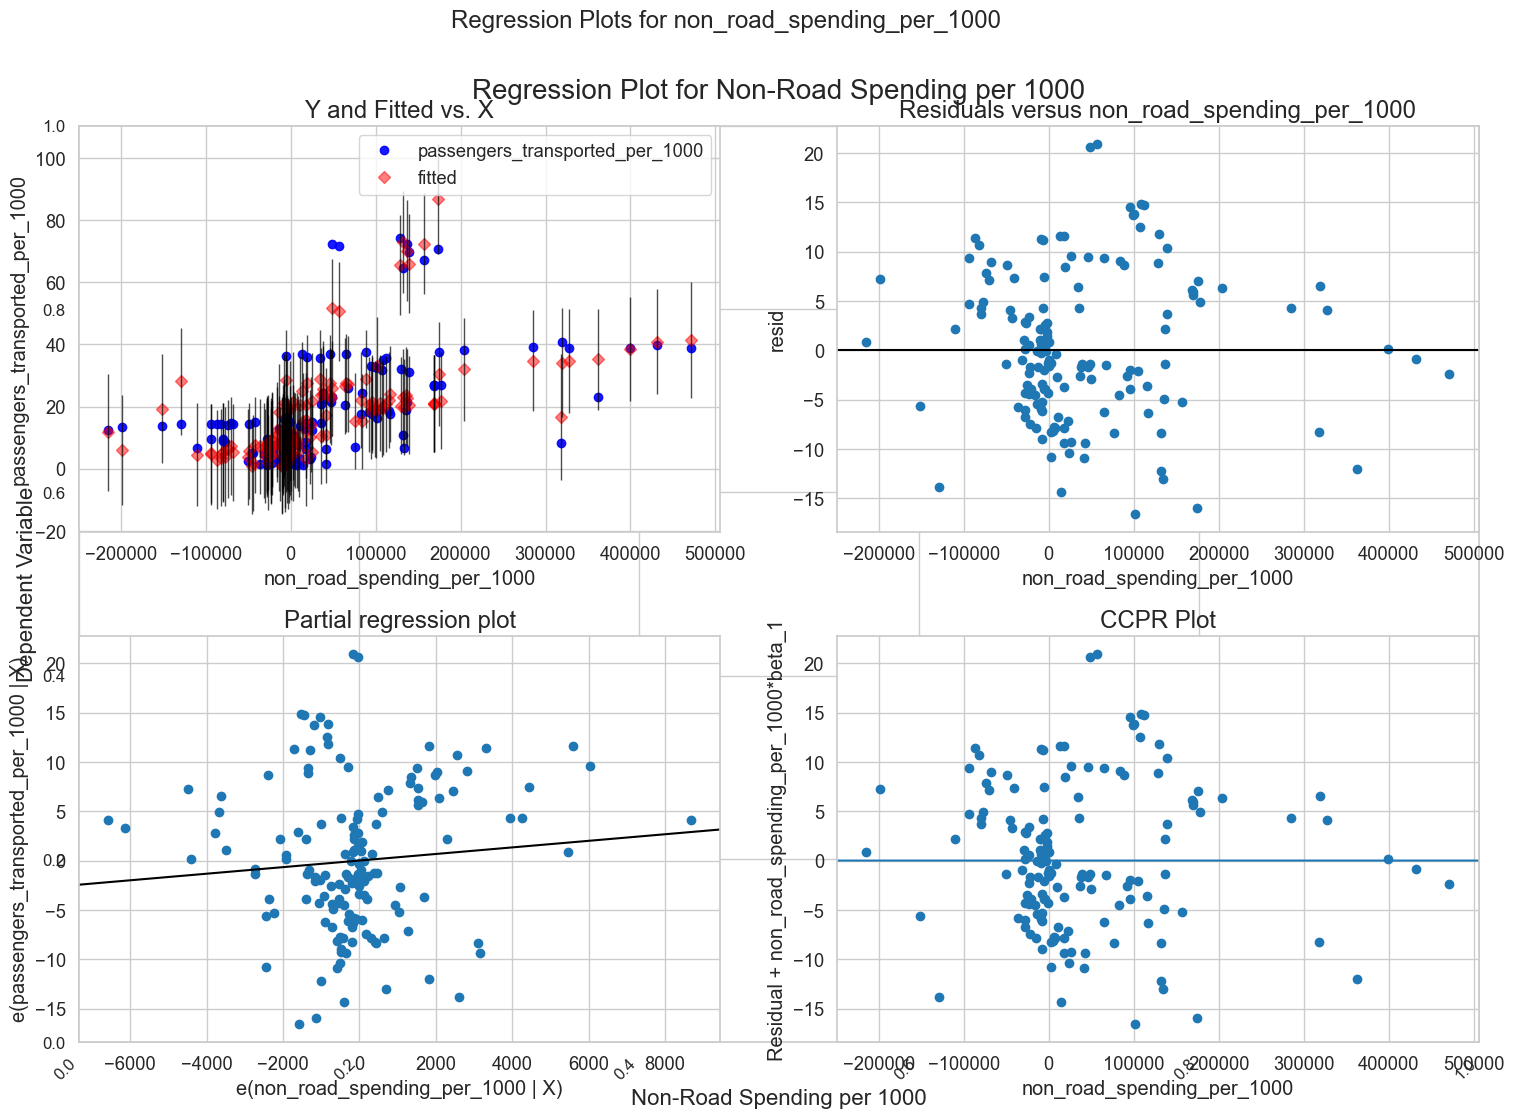

In [477]:
# Set the style and context for the plot
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.2)

# Create the regression plot with a larger figsize and slanted x-axis tick labels
fig, ax = plt.subplots(figsize=(16, 12))
sm.graphics.plot_regress_exog(model4, 'non_road_spending_per_1000', fig=fig)

# Manually set the x-axis tick positions and labels
x_tick_positions = ax.get_xticks()
x_tick_labels = ax.get_xticklabels()
ax.set_xticks(x_tick_positions)
ax.set_xticklabels(x_tick_labels, rotation=45, ha='right')

# Customize the plot
ax.set_title("Regression Plot for Non-Road Spending per 1000", fontsize=20, pad=20)
ax.set_xlabel("Non-Road Spending per 1000", fontsize=16)
ax.set_ylabel("Dependent Variable", fontsize=16)

# Set the tick labels
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)

# Adjust spacing between subplots
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Tighten layout
fig.tight_layout()

# Show the plot
plt.show()


In [470]:
# non_road_spending_per_1000*passenger_cars_per_1000*inland_investment_per_1000*road_spending_per_1000
y_pred = model4.predict(transportation_data[['non_road_spending_per_1000', 'passenger_cars_per_1000', 'inland_investment_per_1000', 'road_spending_per_1000']])

In [471]:
# Get y_actual
y_actual = transportation_data['passengers_transported_per_1000']

# Calculate the residuals
residuals = y_actual - y_pred

# Calculate the mean of squared residuals
mse = np.mean(residuals**2)

# Calculate the RMSE
rmse = np.sqrt(np.mean(residuals**2))

print("RMSE:", rmse)

RMSE: 7.408263453830051


In [472]:
# indicates performance of OLS model - lower is better, and we got lower
squared_rmse = rmse**2
squared_rmse

54.88236740135395

Our RMSE went down by half when increasing the number of variables, which means that our model improved in terms of fit. However, we still need to be careful wtih the amount of error, because our model might not be that reliable in predicting values for new countries.